# Load and test pre-trained models



In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import SymLogNorm
from tensorflow.keras.models import load_model

import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess
from src.model import transform_batch, plot_history

models_path = "../../models/"

In [15]:
datestring = "2024_06_03T092350"
model_path = os.path.join(models_path,datestring) + ".keras"
model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,203 (12.52 KB)

 Trainable params: 1,063 (4.15 KB)

 Non-trainable params: 12 (48.00 B)

 Optimizer params: 2,128 (8.32 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: title={'center': 'Last 15 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

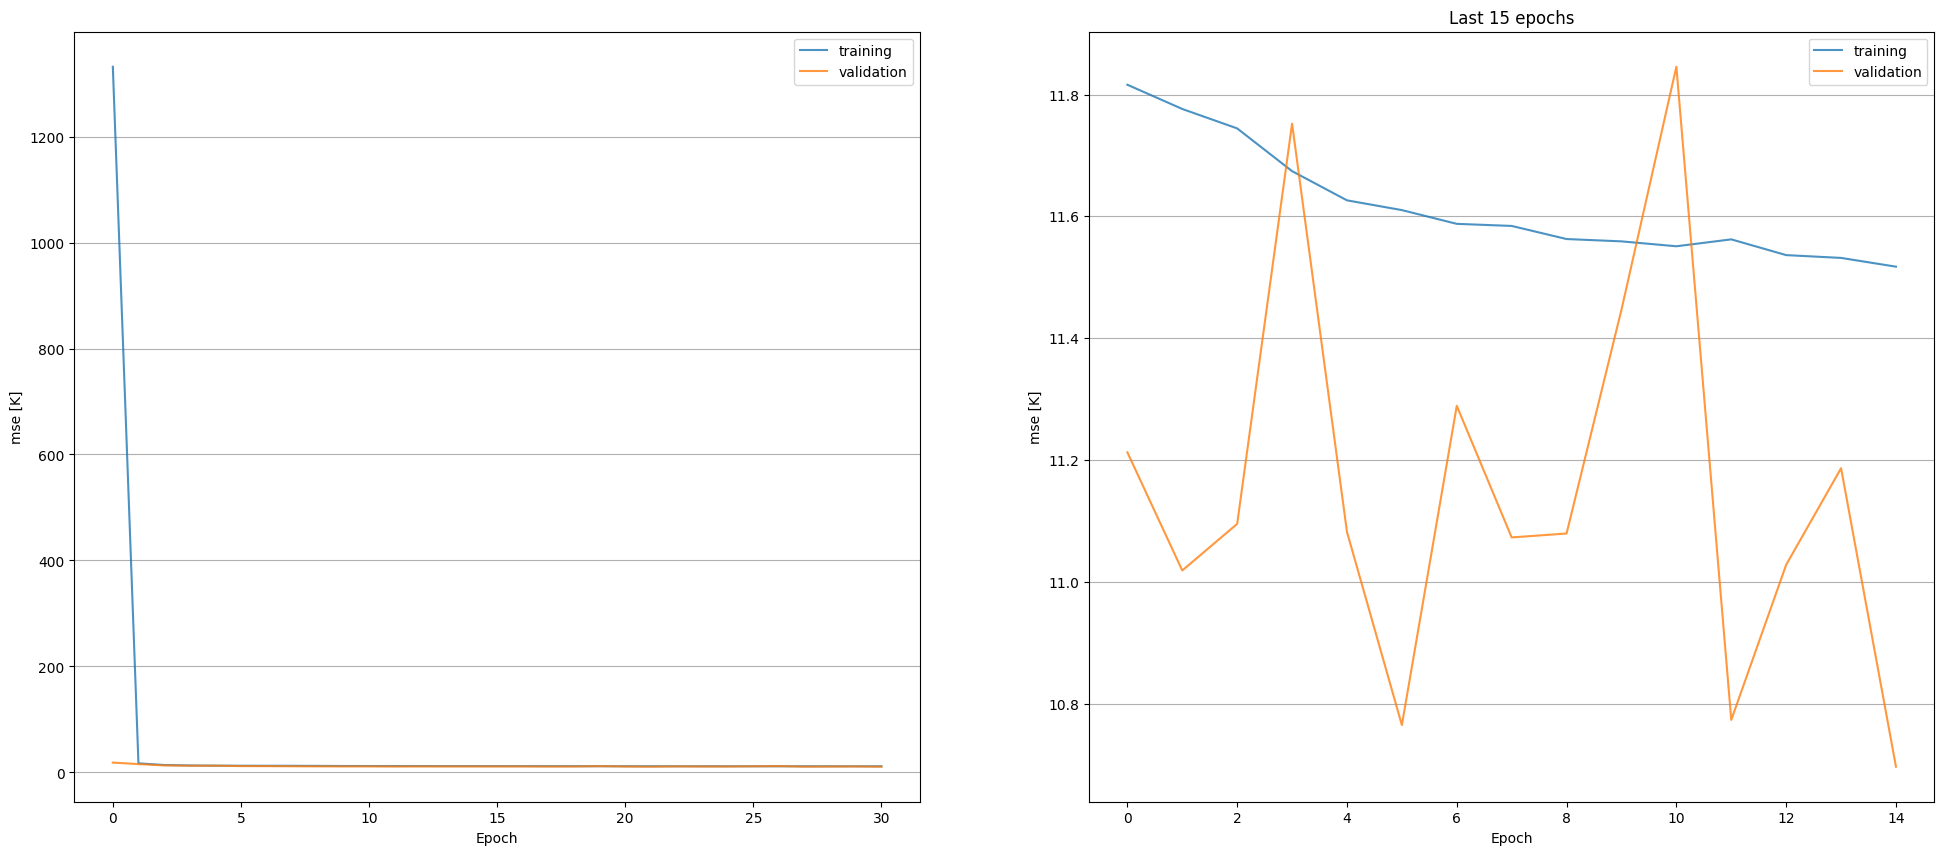

In [16]:
# Load and plot training history
history_path = os.path.join(models_path, datestring) + "_history"
with open(history_path, "rb") as file:
    history = pickle.load(file)
plot_history(history)


In [17]:

folder_path = "../../data/raw/Daily_Windsat/"
# Load windsat dataset, and trasnform it to feed it to the model
ds = windsat_datacube(folder_path)
ascds = model_preprocess(ds)

ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)

transfomed_df = transform_batch(ascds_df)

# Remove the time of observation, FOR SOME MODELS
transfomed_df = transfomed_df[
    [col for col in transfomed_df.columns if col not in 
        ["time_18Ghz","time_37Ghz","day_number"]
    ]
]

# Predict on the model and append the predicted srutep
ascds_df["surtep_MODEL"] = model.predict(transfomed_df[[col for col in transfomed_df.columns if col != "surtep_ERA5"]])
ascds_df["error"] = ascds_df["surtep_ERA5"] - ascds_df["surtep_MODEL"]
ascds_df

17874/17874 ━━━━━━━━━━━━━━━━━━━━ 10s 562us/step


,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,surtep_MODEL,error
212694,1,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,5.365944e+08,5.365944e+08,288.132355,-12.237915
232835,1,276.849609,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,5.365944e+08,5.365945e+08,288.296570,-11.446960
232838,1,277.820099,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,5.365944e+08,5.365945e+08,286.212433,-8.392334
232839,1,278.050476,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,5.365944e+08,5.365944e+08,286.400055,-8.349579
232840,1,277.954346,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,5.365944e+08,5.365944e+08,287.261108,-9.306763
...,...,...,...,...,...,...,...,...,...,...,...,...
21661288,21,276.515686,70.625,22.125,202.862488,140.917496,215.862503,169.722504,5.383268e+08,5.383268e+08,274.061066,2.454620
21661289,21,275.758698,70.625,22.375,208.297485,151.820007,217.259995,175.607498,5.383268e+08,5.383268e+08,271.847870,3.910828
21705886,21,275.418823,78.375,11.625,196.614990,127.227493,208.505005,153.690002,5.383269e+08,5.383269e+08,273.978760,1.440063
21705887,21,275.177582,78.375,11.875,196.882492,127.707497,208.345001,153.547501,5.383269e+08,5.383269e+08,273.775818,1.401764


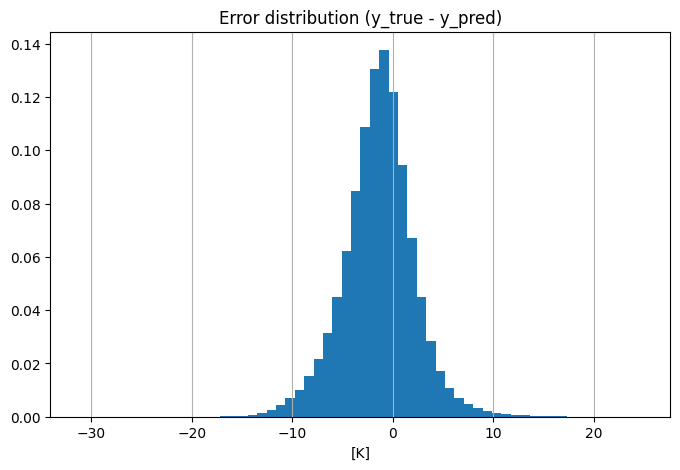

In [18]:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = ascds_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

### NOTE:
Since the testing dataset is Jan 1st to Jan 21st, the mse should be biased towards negative values (aka, day_number is not doing anything ... )

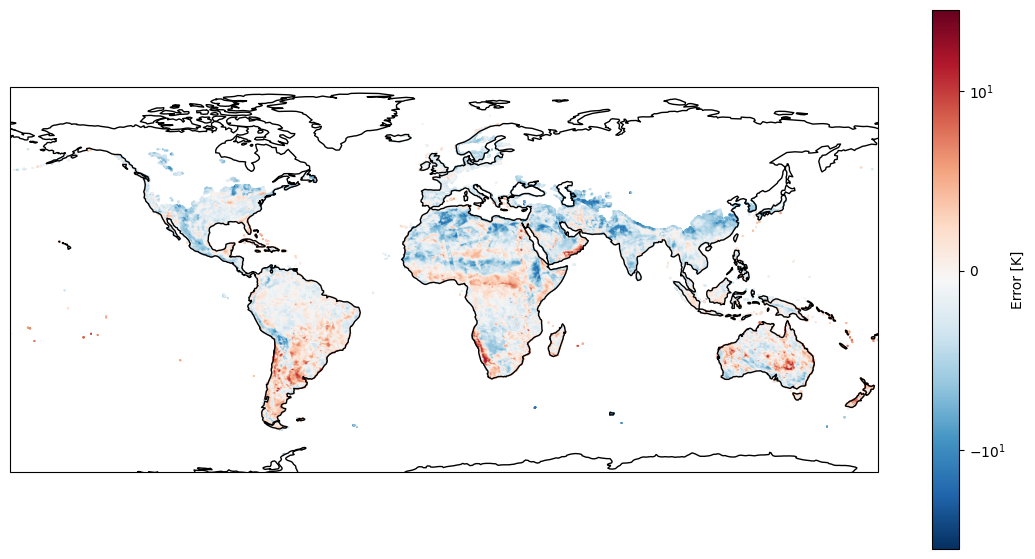

In [19]:
# Testing by predicting the whole dataset:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = SymLogNorm(linthresh=11)

scatter = ax.scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()


### Some areas with poor performance

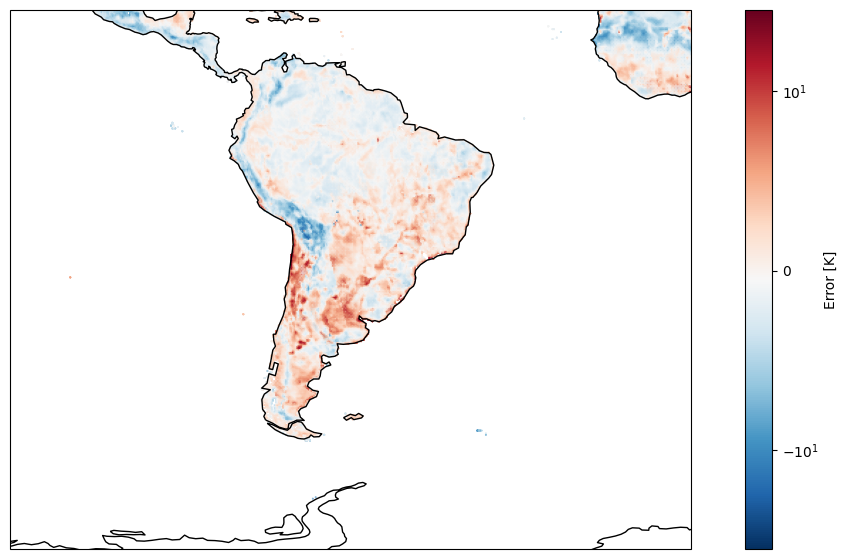

In [20]:
south_america = [(-75,20),(-120,0)]

ax.set_ylim(south_america[0])
ax.set_xlim(south_america[1])

fig

### This consistent over-estimation of the temperature in high grounds could be due to the model not beeing altitude-aware

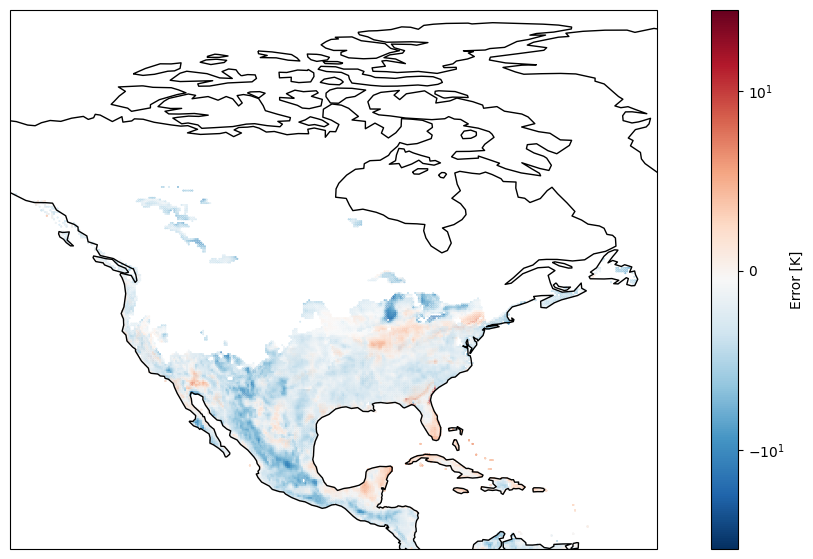

In [21]:
# Selec some problematic areas:
north_america = [(10,85),(-140,-50)]

ax.set_ylim(north_america[0])
ax.set_xlim(north_america[1])

fig

### Big lakes (Michigan) mess up the model too, we should remove Water bodies from training, maybe  also in validation.

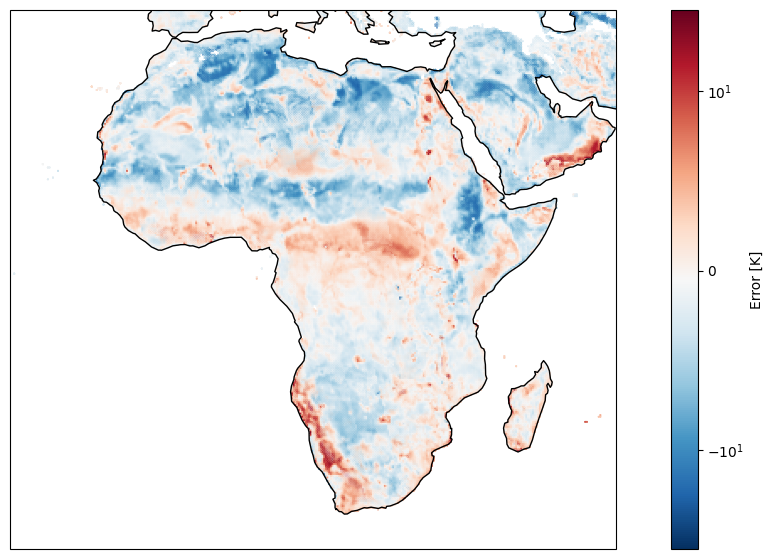

In [22]:
central_africa = [(-40,40),(-30,60)]

ax.set_ylim(central_africa[0])
ax.set_xlim(central_africa[1])

fig

### Some very high error (predicted temp is hoter than measured) near the small lakes in central africa.

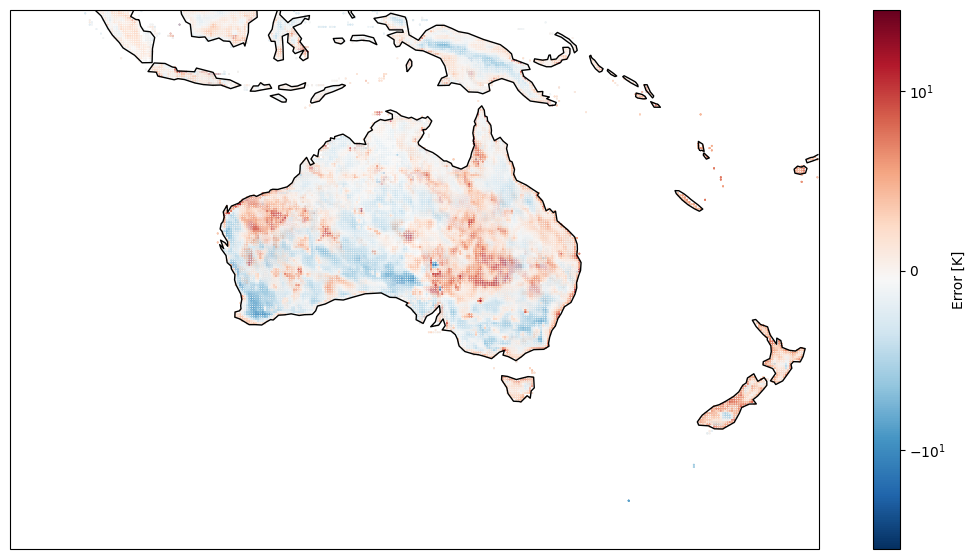

In [23]:
australia = [(-60,0),(90,180)]

ax.set_ylim(australia[0])
ax.set_xlim(australia[1])

fig

#### Lets plot the surtep from ERA5 and the model side by side to see if the features are a product of the real data or not

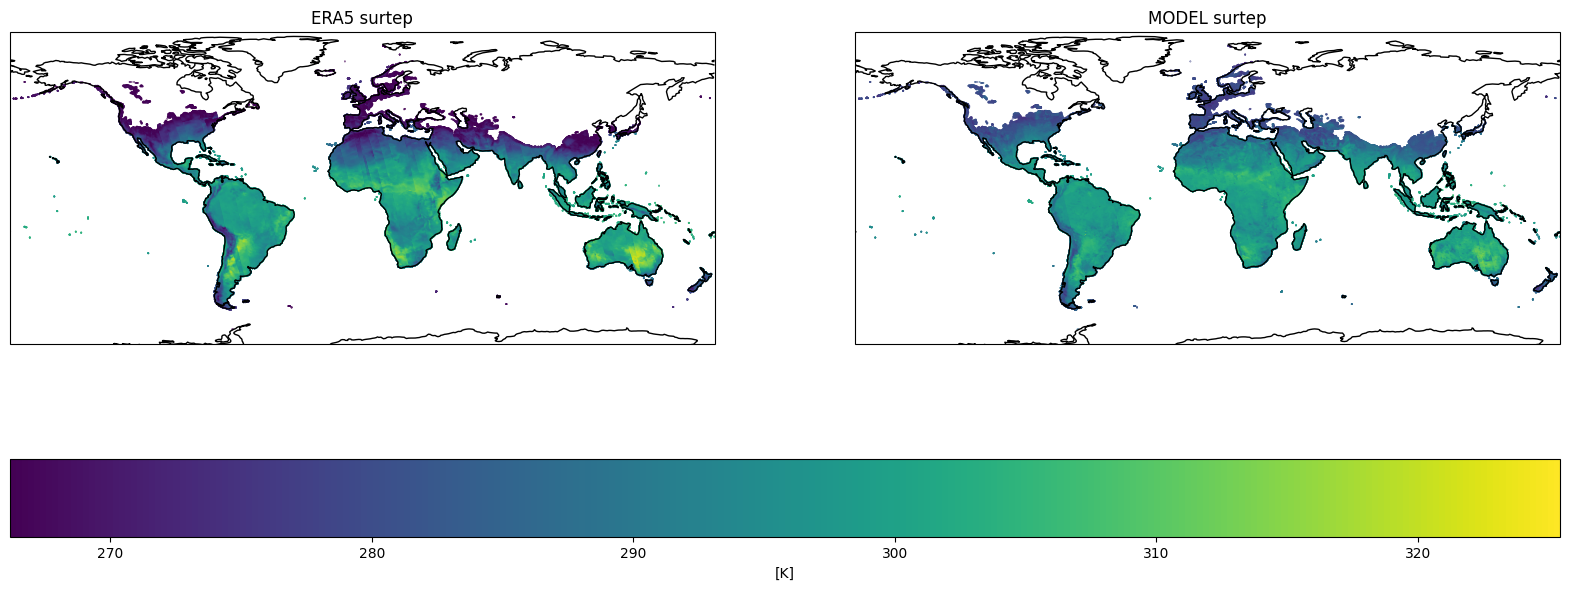

In [24]:
# Testing by predicting the whole dataset:
fig, ax = plt.subplots(1,2,figsize = (20,10), subplot_kw={"projection":ccrs.PlateCarree()} )

ax[0].coastlines("110m")
ax[1].coastlines("110m")

scatter = ax[0].scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["surtep_ERA5"],
    cmap = "viridis",
)
ax[0].set_title("ERA5 surtep")

scatter = ax[1].scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["surtep_MODEL"],
    cmap = "viridis",
)
ax[1].set_title("MODEL surtep")


fig.colorbar(scatter, ax=ax, orientation='horizontal', label='[K]')
plt.show()

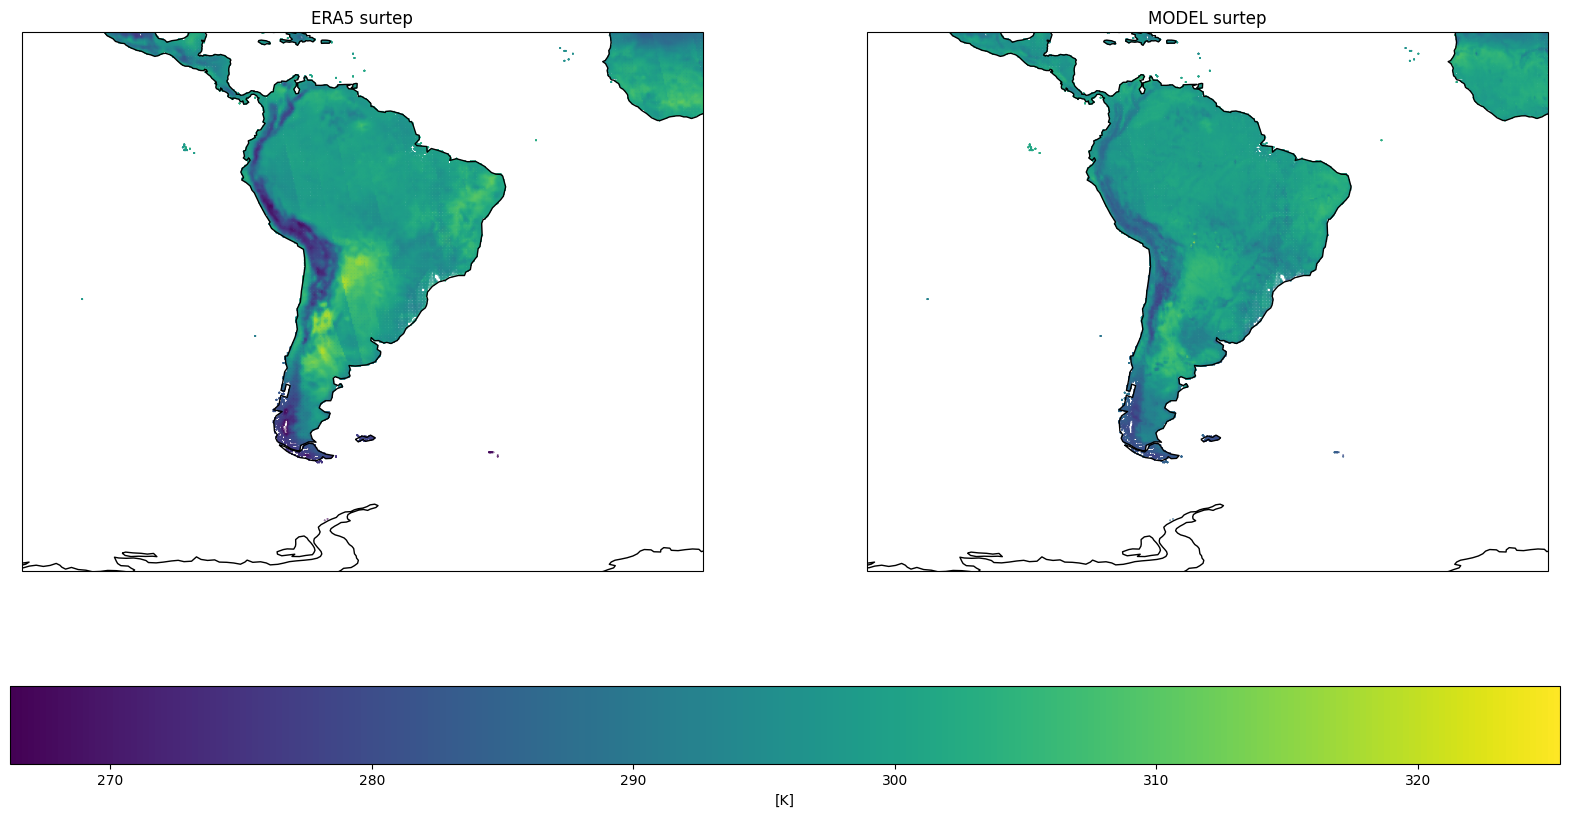

In [25]:
south_america = [(-75,20),(-120,0)]

ax[0].set_ylim(south_america[0])
ax[0].set_xlim(south_america[1])

ax[1].set_ylim(south_america[0])
ax[1].set_xlim(south_america[1])

fig

--- 

# MODEL VERSION 2: 

Winsat tbtoa + TELSEM emissivities

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import CenteredNorm
from tensorflow.keras.models import load_model

import xarray as xr
import pandas as pd
import numpy as np
import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess, create_landmask
from src.model import transform_batch, plot_history, xy_split

models_path = "../../models/"

In [2]:
#TELSEM ATLAS
telsem_folder = "../../data\processed\WinsatEmiss"

# Preprocessing of TELSEM atlas:
telsem_ds = xr.open_mfdataset(
    paths = "../../data/processed/WinsatEmiss/*.nc",
    engine="netcdf4",
    concat_dim="month",
    combine="nested"
)

# Select only the desired data variables:

d_vars = [
    "Emis19V",
    "Emis19H",
    "Emis37V",
    "Emis37H",
]

telsem_ds = telsem_ds[d_vars]

#roll the longitude to align the data
telsem_ds = telsem_ds.roll(
    {
        "longitude_grid" : 4 * 180
    }
)

landmask = create_landmask(lat = telsem_ds.lat.values, lon= telsem_ds.lon.values)
telsem_ds["landmask"] = (("latitude_grid","longitude_grid"),landmask.values)

telsem_ds = telsem_ds.where(telsem_ds.landmask == 0)
telsem_ds = telsem_ds.drop_vars("landmask")
telsem_ds = telsem_ds.reset_coords()

telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")


In [3]:
# WINDSAT data
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ascds= model_preprocess(ds)

# Select the variables from windsat that we need:
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

ascds = ascds[d_vars]

asc_df = ascds.to_dataframe().dropna().reset_index("day_number")

# Map the day of the year (day_number) into the month:
day_mapping = []
days_in_months = [31,29,31,30,31,30,31,31,30,31,30,31]

for i, n in enumerate(days_in_months):
    to_add = [i +1] * n
    day_mapping.extend(to_add)
len(day_mapping)


asc_df["month"] = asc_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
asc_df = asc_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=asc_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.647545,0.383990,0.728690,0.499140
1,276.849609,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,0.731963,0.531646,0.787510,0.611650
2,277.820099,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,0.781347,0.616654,0.837876,0.710351
3,278.050476,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,0.761607,0.580606,0.821349,0.674506
4,277.954346,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,0.732011,0.528308,0.794148,0.618672
...,...,...,...,...,...,...,...,...,...,...,...
571961,276.515686,70.625,22.125,202.862488,140.917496,215.862503,169.722504,0.716794,0.495456,0.738237,0.519161
571962,275.758698,70.625,22.375,208.297485,151.820007,217.259995,175.607498,0.735197,0.525839,0.750326,0.547016
571963,275.418823,78.375,11.625,196.614990,127.227493,208.505005,153.690002,0.806743,0.616019,0.824079,0.655345
571964,275.177582,78.375,11.875,196.882492,127.707497,208.345001,153.547501,0.832185,0.659286,0.842818,0.700909


In [5]:
# Load a model
datestring = "WSMv2_" + "2024_06_07T101014"
model_path = os.path.join(models_path, datestring + ".keras")
history_path = os.path.join(models_path, datestring + "_history")

model = load_model(model_path)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,595 (14.05 KB)

 Trainable params: 1,191 (4.65 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 2,384 (9.32 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K])'>,
        <Axes: title={'center': 'Last 353 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

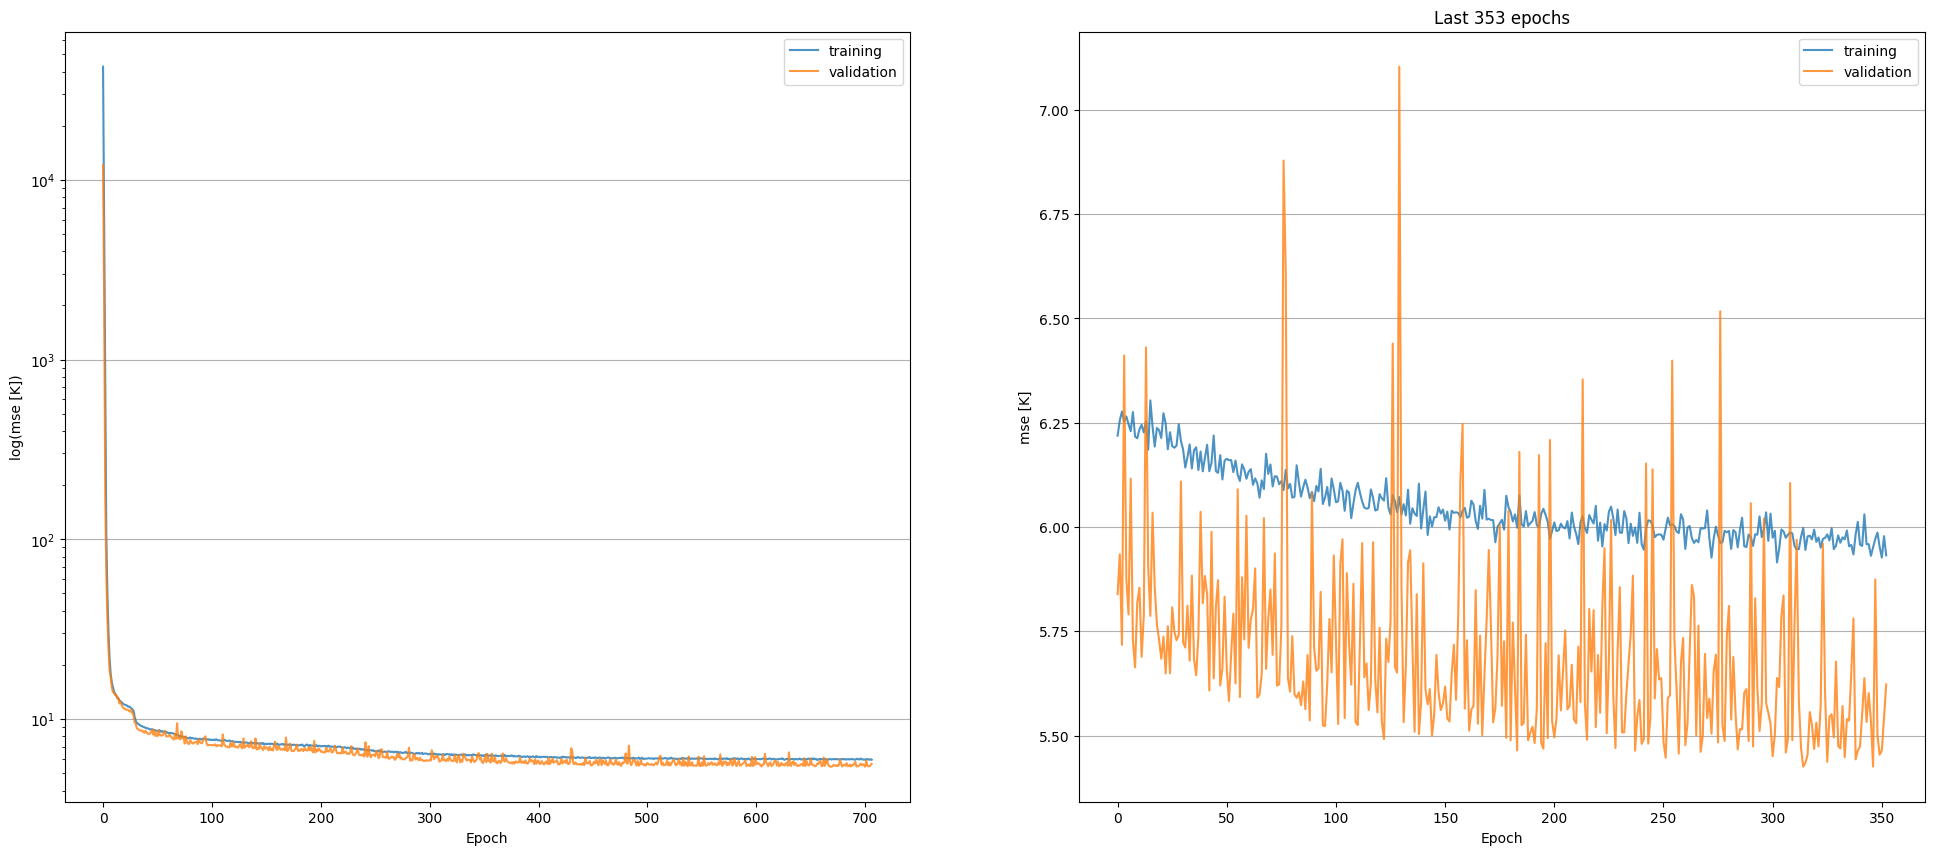

In [6]:

with open(history_path, "rb") as file:
    history = pickle.load(file)

plot_history(history)

In [7]:
# Predict for the local sample and plot:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

17874/17874 ━━━━━━━━━━━━━━━━━━━━ 9s 484us/step


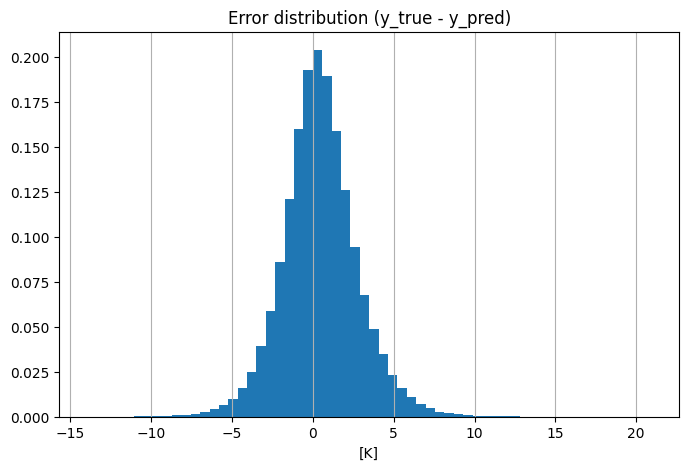

In [8]:
# Error histogram:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

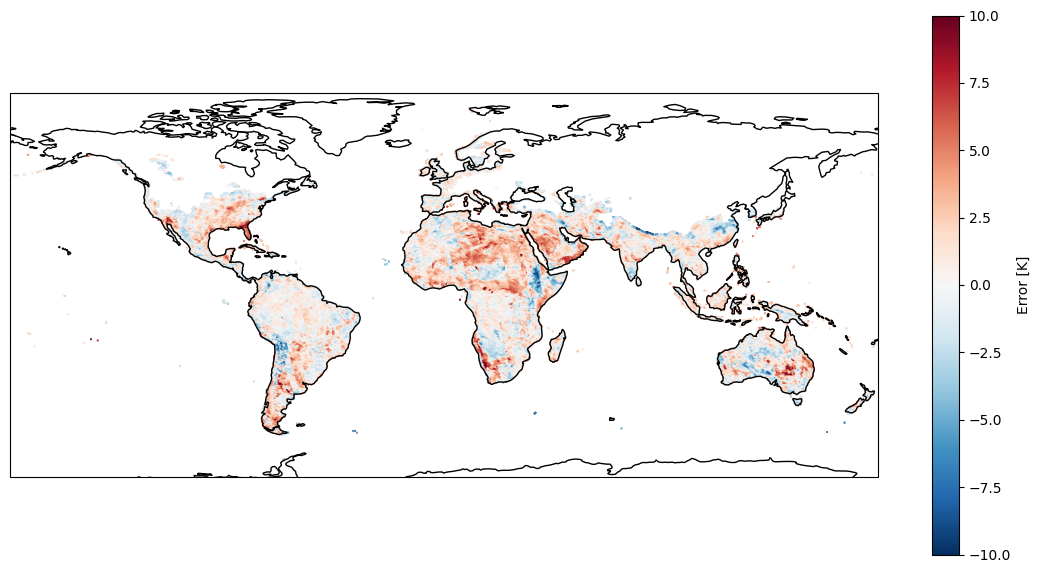

In [11]:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0, halfrange=10, clip= False)

scatter = ax.scatter(
    x = combined_df["lon"],
    y =combined_df["lat"],
    s= 0.1,
    alpha = 1,
    c=combined_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()


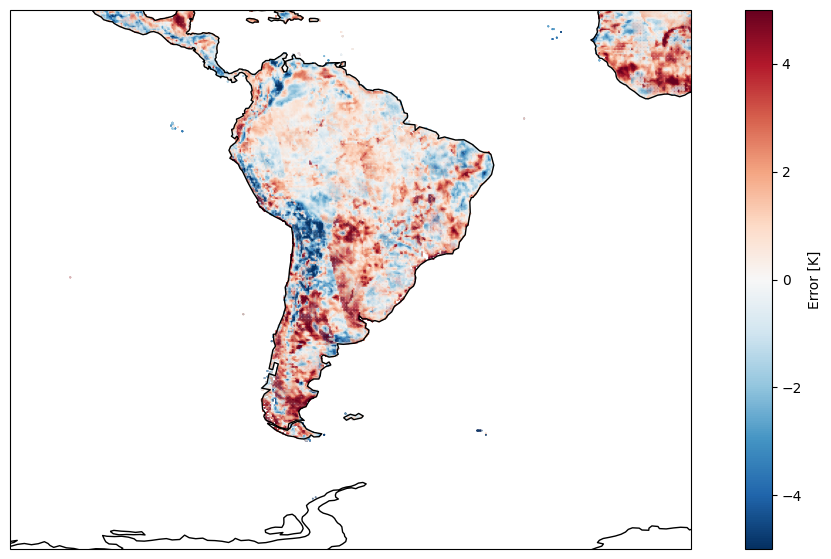

In [10]:
south_america = [(-75,20),(-120,0)]

ax.set_ylim(south_america[0])
ax.set_xlim(south_america[1])

fig